# Generating discrete random variables #

## The inverse transformation method ##

Let $X$ denote a random variable whose discrete distribution has $x_1, \dots x_n, \dots$ as mass points and $p_1, \dots, p_n, \dots$ as corresponding probability values. Assume that $\mathrm{random}$ is a pseudorandom function whose returned values can be used as specifications of the uniform distribution over $[0, 1]$. Consider the following (probabilistic) algorithm.

- $u = \mathrm{random()}$;
- if $u < p_1$ return $x_1$;
- if $p_1 \leq u < p_1 + p_2$ return $x_2$;
- if $p_1 + p_2 \leq u < p_1 + p_2 + p_3$ return $x_3$;
- $\dots$
- if $\sum_{j=1}^{i-1}p_j \leq u < \sum_{j=1}^i p_j$ reutrn $x_i$;
- $\dots$

Note that the generic if statement relies on the implicit assumption that $\sum_{j=1}^0 p_j = 0$. If we denoste by $X_G$ the random variable whose specifications are the values returned by this algorithm, it is easy to see that $X_G = x_i$ if and only if

$$\sum_{j=1}^{i-1}p_j \leq U < \sum_{j=1}^i p_j,$$

where $U$ is a random variable uniformly distributed over $[0, 1]$ and $F_U$ denostes its c.d.f. Thus, for any $i=1, \dots, n, \dots$,

$$
\mathrm P(X_G=x_i) = \mathrm P \left( \sum_{j=1}^{i-1}p_j \leq U < \sum_{j=1}^i p_j \right)
= F_U\left( \sum_{j=1}^i p_j \right) - F_U\left( \sum_{j=1}^{i-1}p_j \right)
= \sum_{j=1}^i p_j - \sum_{j=1}^{i-1}p_j = p_i = \mathrm P(X = x_i).
$$

This implies that $X_G$ has the same distribution of $X$, and given that the latter can encode any discrete distribution, the previous algorithm can be used in order to simulate a generic discrete random variable. We can therefore set up the following general-purpose routine for simulating a given discrete distribution.

In [1]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from scipy import random
from ipywidgets import widgets, interact
from IPython.display import display, clear_output

In [2]:
def simulate_discrete_rv(vals, probs, n=1):
    cum_probs = np.cumsum(probs)
    result = []
    for k in range(n):
        u = random.random()
        i = 0
        while u >= cum_probs[i]:
            i += 1
        result.append(vals[i])
    return result if n > 1 else result[0]

Such approach to simulation is called the _inverse transformation_ method, because the algorithm we used computes a sort of inverse of the cumulatinve distribution function of $U$, as visible in the following panel, where we consider the distribution over the values 1, 2, 4, and 7 respectively occurring with probabilities equal to 0.3, 0.1, 0.2, and 0.4. At each simulation a different starting random value is generated, and subsequently the inverse transformation method is applied in order to find the corresponding specification.

<IPython.core.display.Javascript object>


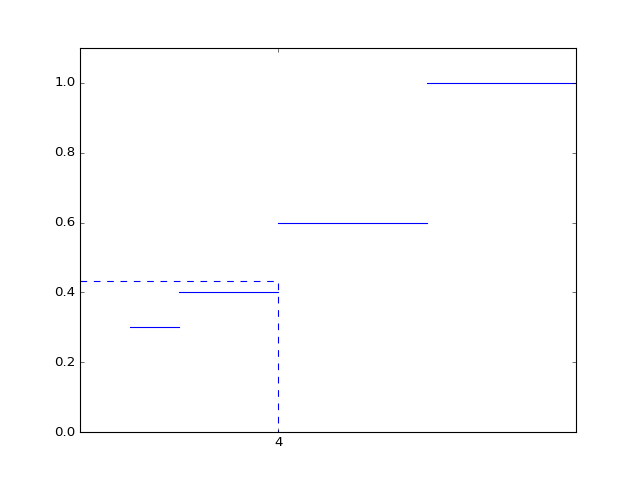

In [3]:
%matplotlib notebook

vals = [1, 2, 4, 7]
probs = [.3, .1, .2, .4]

fig_inv, ax_inv = plt.subplots()

cum_probs = np.cumsum(probs)
    
def change_u(button):
    u = random.random()
    i = 0
    while u >= cum_probs[i]:
        i += 1
    
    ax_inv.clear()
    
    vals_ext = vals + [10]
    for line in zip(zip(vals_ext[:-1], vals_ext[1:]), cum_probs):
        ax_inv.plot(line[0], [line[1]]*2, 'b')
    
    v = simulate_discrete_rv(vals, probs)

    plt.ylim(0, 1.1)
    _ = plt.xticks([vals[i]])

    _ = ax_inv.plot([0, vals[i], vals[i]], [u, u, 0], '--b')

button_change_u = widgets.Button(description="Change u")
button_change_u.on_click(change_u)
change_u(button_change_u)

display(button_change_u)

Note that $F_U$ is not invertible, beacuse of the lack of continuity when its argument is one of the mass points of the distribution. In spite of this, all points for which the inverse is not defined are correctly handled by the proposed algorithm, for they are assigned to the mass points.

As a tool for tesing our implementation we can use the empirical c.d.f. of a generated sample. We report here its implementation introduced in Lecture 2.

In [4]:
def ecdf(data):
    sorted = np.sort(data)
    yvals = np.arange(len(sorted))/float(len(sorted))
    return((sorted, yvals))

The simplest test consists obviously in generating, say, five thousand values and superimpose their empirical c.d.f. with that of the original distribution. This is precisely what is done in the following panel, restarting the process each time the button is clicked.

<IPython.core.display.Javascript object>


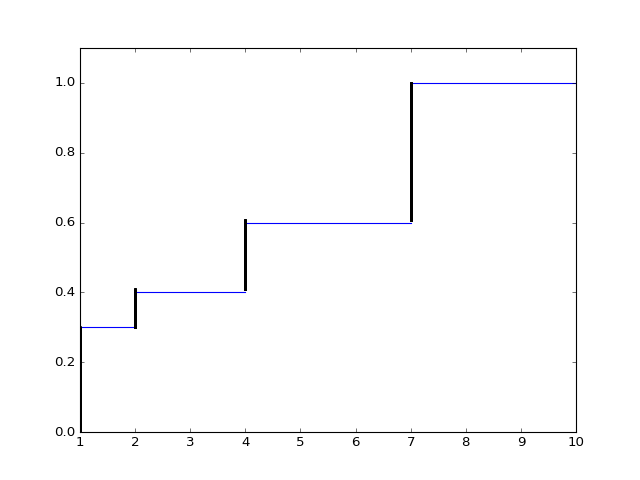

In [5]:
fig_ecdf, ax_ecdf = plt.subplots()

def new_sample(button):
    data = simulate_discrete_rv(vals, probs, 5000)
    
    ax_ecdf.clear()
    
    vals_ext = vals + [10]
    for line in zip(zip(vals_ext[:-1], vals_ext[1:]), cum_probs):
        ax_ecdf.plot(line[0], [line[1]]*2, 'b')
        
    x_ecdf, y_ecdf = ecdf(data)
    ax_ecdf.plot(x_ecdf, y_ecdf, 'ko', markersize=2, alpha=.7)
    plt.ylim(0, 1.1)

button_new_sample = widgets.Button(description="Simulate")
button_new_sample.on_click(new_sample)
new_sample(button_new_sample)

display(button_new_sample)

The general-purpose algorithm used up to now can be restated in a form tailored for this specific distribution:

- $u = \mathrm{random}()$
- if $u < .3$ return 1
- if $u < .4$ return 2
- if $u < .6$ return 4
- return 7

Now consider the following variant of this algorithm:

- $u = \mathrm{random}()$
- if $u < .4$ return 7
- if $u < .7$ return 1
- if $u < .9$ return 4
- return 2

The difference between the two algorithms lays exclusively in the order in which specifications are considered. Thus from a functional point of view there is no reason to prefer one variant over the other one. Things are different if we analyze the average time complexity: indeed, let $N_1$ and $N_2$ denote the random variables accounting for the number $n$ of instruction exectuted and of conditions evaluated during an execution of the two variants. The following table illustrates the probability distributions of these two variables.

|$n$|$\mathrm P(N_1=n)$|$\mathrm P(N_2=n)$|
|-|--|--|
|3|0.3|0.4|
|5|0.1|0.3|
|7|0.2|0.2|
|8|0.4|0.1|

Using this table it is easy to compute the expected values of $N_1$ and $N_2$, that is the average time complexity of the two variants of the algorithm:

$$
\mathbb E(N_1) = 3 \cdot 0.3 + 5 \cdot 0.1 + 7 \cdot 0.2 + 8 \cdot 0.4 = 6 \\
\mathbb E(N_2) = 3 \cdot 0.4 + 5 \cdot 0.3 + 7 \cdot 0.2 + 8 \cdot 0.1 = 4.9
$$

Thus the second variant has a time complexity 18% smaller than the first one. This is due to the fact that specifications are scanned in decreasing order of probability, therefore most of the time the algorithm will return after having considered a small number of alternatives. This means that when the number of specifications is finite the general-purpose simulation procedure will benefit from a rearrangement of values in decreasing probability order, for instance using the following function.

In [6]:
def optimize_distribution(vals, probs):
    sorted_ind = np.argsort(probs)[::-1]
    return ([vals[i] for i in sorted_ind],
            [probs[i] for i in sorted_ind])

## Simulating a Bernoulli distribution ##

The application of the inverse transformation method to a Bernoulli distribution of parameter $p \in [0, 1]$ is straightforward: let $X$ denote a random variable following this distribution, that is $\mathrm P(X=x) = p^x (1-p)^{1-x} \mathrm I_{\{0, 1\}}(x)$. If we apply the method with $x_1=1$ and $x_2=0$ we obtain the following algorithm:

- $u = \mathrm{random}()$
- if $u < p$ return 1
- return 0

We would get the same effect considering $x_1=0$ and $x_2=1$, and in both cases the implementation is a one-liner in most programming languages.

In [17]:
def bernoulli(p):
    return 1 if random.random() < p else 0

Note that this algorithm would have the following, very succint implementation in the C programming language:

```return rand() < p;```

because of the peculiar way of this language in encoding boolean values into integer ones.

The following panel implements a simple test of the proposed python implementation comparing as before the theorical c.d.f. with the empirical c.d.f. obtained from a randomly generated sample once the distribution parameter has been fixed to $p=0.25$.

<IPython.core.display.Javascript object>


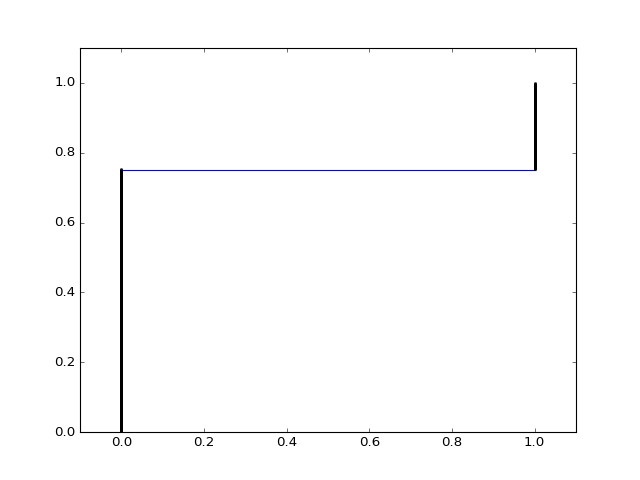

In [21]:
%matplotlib notebook

fig_bernoulli, ax_bernoulli = plt.subplots()
vals = np.arange(0, 2)
p = 0.25
probs = (1-p, p)
cum_probs = np.cumsum(probs)

def new_sample(button):
    data = [bernoulli(p) for i in range(1000)]
    
    ax_bernoulli.clear()
        
    for line in zip(zip(vals[:-1], vals[1:]), cum_probs):
        ax_bernoulli.plot(line[0], [line[1]]*2, 'b')
            
    x_ecdf, y_ecdf = ecdf(data)
    ax_bernoulli.plot(x_ecdf, y_ecdf, 'ko', markersize=2, alpha=.7)
    plt.ylim(0, 1.1)
    plt.xlim(-0.1, max(vals)*1.1)

button_new_sample = widgets.Button(description="Simulate")
button_new_sample.on_click(new_sample)
new_sample(button_new_sample)

display(button_new_sample)

In order to perform a more extensive test, the following panel implements a richer experiment allowing to automatically execute the empirical c.d.f.-based check for different values of $p$ to be chosen through a slider.

<IPython.core.display.Javascript object>


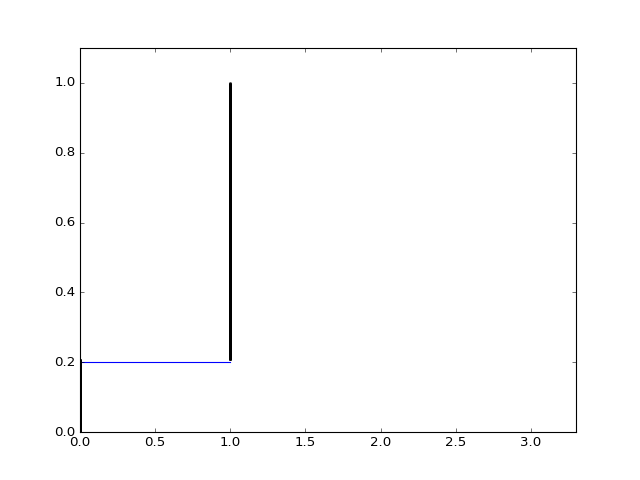

In [22]:
bernoulli_button = widgets.Button(description='Simulate')
bernoulli_p_selector = widgets.FloatSlider(min=0, max=1, value=0.25)

fig_bernoulli_simulation, ax_bernoulli_simulation = plt.subplots()

def bernoulli_simulation(p):
    data = [bernoulli(p) for i in range(1000)]
    vals = (0, 1)
    probs = (1-p, p)
    cum_probs = np.cumsum(probs)

    clear_output()
    ax_bernoulli_simulation.clear()
        
    for line in zip(zip(vals[:-1], vals[1:]), cum_probs):
        ax_bernoulli_simulation.plot(line[0], [line[1]]*2, 'b')
            
    x_ecdf, y_ecdf = ecdf(data)
    ax_bernoulli_simulation.plot(x_ecdf, y_ecdf, 'ko', markersize=2, alpha=.7)
    plt.ylim(0, 1.1)
    plt.xlim(0, max(vals)*1.1)
    
    display(fig_bernoulli_simulation)


bernoulli_button.on_click(lambda b: bernoulli_simulation(bernoulli_p_selector.value))
display(bernoulli_button)

interact(bernoulli_simulation, p=bernoulli_p_selector)

## Simulating a uniform discrete distribution ##

If we consider the uniform discrete distribution, the application of the inverse transformation method can be done in a smarter way than the trivial execution of the loop cycling through all specification values. Let $X$ be distributed uniformly over $\{1, \dots, n\}$ for $n \in \mathbb N\backslash \{ 0 \}$, that is $\mathrm P(X=i) = \frac{1}{n} \mathrm I_{\{1, \dots, n\}}(i)$. As

$$
F_X(x) = \mathrm P(X \leq x) = \sum_{i \leq x}\mathrm P(X=i)
       = \sum_{i=1}^{\lfloor x \rfloor} \frac{1}{n} = \frac{\lfloor x \rfloor}{n},
$$

any $u \in [0, 1]$ will identify the specification $i$ such that $F_X(i-1) \leq u < F_X(i)$, that is

$$
\frac{i-1}{n} \leq u \leq \frac{i}{n}.
$$

The latter equation is equivalent to $i-1 \leq n u < i$ and thus $i = \lceil n u \rceil$. This allows us to simulate a discrete uniform distribution without actually cycling over all possible specifications, but relying on the following one-line routine.

In [7]:
def uniform_discrete(n):
    return int(1 + random.random() * n)

This routine is tested as above through the superposition of the graph of $F_X$ with that of the empirical c.d.f. of a sample generated through `uniform_discrete`. This is done in the following panel for the special case $n=4$ and considering a sample of one thousand elements, which are generated anew each time the button is pressed.

<IPython.core.display.Javascript object>


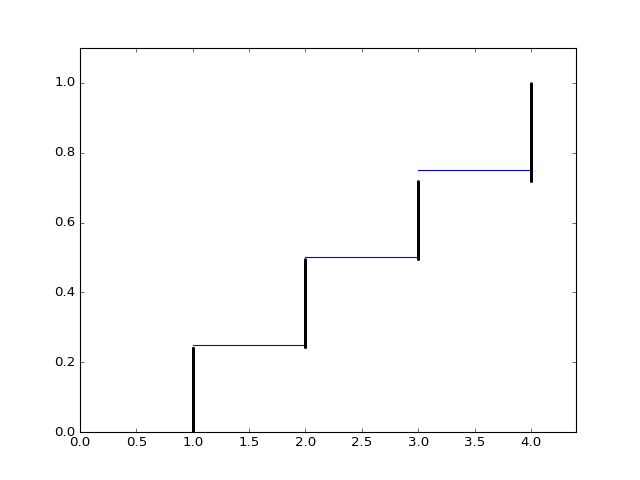

In [18]:
%matplotlib notebook

fig_discrete_unif, ax_discrete_unif = plt.subplots()
vals = np.arange(1, 5)
probs = [1./4] * 4
cum_probs = np.cumsum(probs)

def new_sample(button):
    data = [uniform_discrete(4) for i in range(1000)]
    
    ax_discrete_unif.clear()
        
    for line in zip(zip(vals[:-1], vals[1:]), cum_probs):
        ax_discrete_unif.plot(line[0], [line[1]]*2, 'b')
            
    x_ecdf, y_ecdf = ecdf(data)
    ax_discrete_unif.plot(x_ecdf, y_ecdf, 'ko', markersize=2, alpha=.7)
    plt.ylim(0, 1.1)
    plt.xlim(0, max(vals)*1.1)

button_new_sample = widgets.Button(description="Simulate")
button_new_sample.on_click(new_sample)
new_sample(button_new_sample)

display(button_new_sample)

As already done for the Bernoully distribution, in order to show the generality of this process the following panel repeats the previous experiment, now allowing the user to dynamically select the value for $n$.

<IPython.core.display.Javascript object>


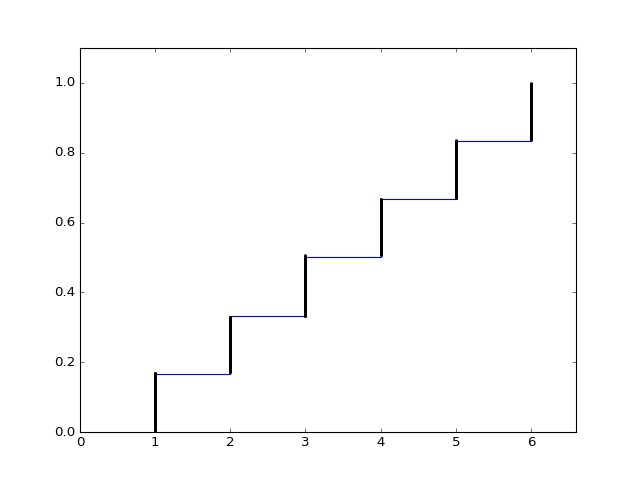

In [12]:
unif_button = widgets.Button(description='Simulate')
unif_n_selector = widgets.IntSlider(min=2, max=10, value=4)

fig_unif_simulation, ax_unif_simulation = plt.subplots()

def uniform_simulation(n):
    data = [uniform_discrete(n) for i in range(1000)]
    vals = np.arange(1, n+1)
    probs = [1./n] * n
    cum_probs = np.cumsum(probs)

    clear_output()
    ax_unif_simulation.clear()
        
    for line in zip(zip(vals[:-1], vals[1:]), cum_probs):
        ax_unif_simulation.plot(line[0], [line[1]]*2, 'b')
            
    x_ecdf, y_ecdf = ecdf(data)
    ax_unif_simulation.plot(x_ecdf, y_ecdf, 'ko', markersize=2, alpha=.7)
    plt.ylim(0, 1.1)
    plt.xlim(0, max(vals)*1.1)
    
    display(fig_unif_simulation)


unif_button.on_click(lambda b: uniform_simulation(unif_n_selector.value))
display(unif_button)

interact(uniform_simulation, n=unif_n_selector)

## Simulating a geometric distribution ##

Consider a random variable $X$ following a geometric distribution characterized by the following probability mass function:

$$
\mathrm P(X=x) = p(1-p)^x \mathrm I_{\mathbb N \cup \{0\}}(x).
$$

This random variable counts the number of insuccesses before the first success in a repeated set of Bernoulli experiments of parameter $p \in (0, 1]$ (note that $p \neq 0$ otherwise $X$ will never have a finite specification). For sake of brevity, denote $q = 1-p$ and note that for each $i \in \mathbb N$

$$
F_X(i) = \mathrm P(X \leq i) = 1 - \mathrm P(X > i) = 1 - q^i.
$$

Indeed, $X > i$ occurs if and only if all the first $i$ experiments had a failure as result, and that happens with probability $q^i$. Thus a generic specification $u$ of the random variable $U$ uniformly distributed over $[0, 1]$ will identify the specification $x$ such that $F_X(x-1) \leq u < F_X(x)$, or equivalently $1-q^{x-1} \leq u < 1-q^x$. Simple rearrangements allow this inequalities to be rewritten as

$$
x-1 \leq \frac{\log (1-u)}{\log q} < x
$$

Summing up,

$$x = \left\lceil \frac{\log (1-u)}{\log q} \right\rceil,$$

or equivalently

$$x = \left\lceil \frac{\log u}{\log q} \right\rceil$$

simply because $U$ and $1-U$ follow the same distribution. Thus also in this case it is possible to set up a one-line implementation of the simulation procedure.

In [23]:
import math

def geometric(p):
    return int(math.log(random.random()) / math.log(1-p))+1

The following panel tests this implementation as already done with the previously introduced distribution.

<IPython.core.display.Javascript object>


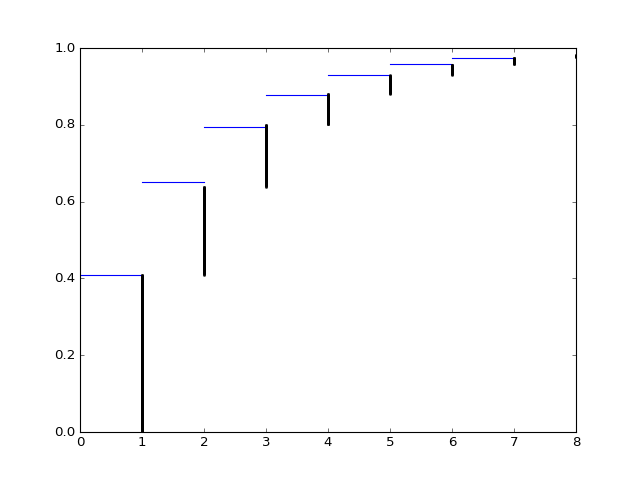

In [43]:
geom_button = widgets.Button(description='Simulate')
geom_p_selector = widgets.FloatSlider(min=0.01, max=1, value=0.3)

fig_geom_simulation, ax_geom_simulation = plt.subplots()

def geometric_simulation(p):
    data = [geometric(p) for i in range(1000)]
    max_x = (int)(math.log(0.01)/math.log(1-p))
    vals = np.arange(0, max_x)
    probs = [p*(1-p)**i for i in range(max_x)]
    cum_probs = np.cumsum(probs)

    clear_output()
    ax_geom_simulation.clear()
        
    for line in zip(zip(vals[:-1], vals[1:]), cum_probs):
        ax_geom_simulation.plot(line[0], [line[1]]*2, 'b')
            
    x_ecdf, y_ecdf = ecdf(data)
    ax_geom_simulation.plot(x_ecdf, y_ecdf, 'ko', markersize=2, alpha=.7)
    plt.ylim(0, 1)
    plt.xlim(0, max_x)
    
    display(fig_geom_simulation)


geom_button.on_click(lambda b: geometric_simulation(geom_p_selector.value))
display(geom_button)

_ = interact(geometric_simulation, p=geom_p_selector)

## Simulating a Poisson distribution ##

In the previous sections we noticed how an analysis of the inverse transformation technique tailored on a specific distribution might lead to a compact implementation for the corresponding simulation algorithm. In case of the Poisson distribution, this technique can be applied almost only in its basic version (although it is possible to resort to other methodologies to simulate the distribution, as we will see later on).

If we denote by $X$ a random variable distributed according to a Poisson distribution of parameter $\lambda > 0$, we will have

$$
\mathrm P(X = i) = \mathrm e^{-\lambda} \frac{\lambda^i}{i!} \mathrm I_{\mathbb N \cup \{ 0 \}}(i).
$$

Thus a direct application of the inverse transformation technique will lead to the following algorithm for simulating $X$:

- $u = \mathrm{random}()$
- $i = 0$
- $p = \mathrm e^{-\lambda}$
- $F = p$
- while $(u \geq F)$:
  - $i = i+1$
  - $p = \mathrm e^{-\lambda} \frac{\lambda^i}{i!}$
  - $F = F + p$
- return $i$

Note that the computation of $p$ within the loop, which is rather expensive, can be replaced by an equivalent operation simply remarking that

$$ p_{i+1} := \mathrm P(X = i+1) = \mathrm e^{-\lambda} \frac{\lambda^{i+1}}{(i+1)!}
            = \frac{\lambda}{i+1} p_i$$

Thus the simulating algorithm can be enhanced (and simplified) if we consider the following variant:

- $u = \mathrm{random}()$
- $i = 0$
- $p = \mathrm e^{-\lambda}$
- $F = p$
- while $(u \geq F)$:
  - $i = i+1$
  - $p = \frac{\lambda}{i}p$
  - $F = F + p$
- return $i$

This variant is implemented as follows.

In [44]:
def poisson(_lambda):
    u = random.random()
    i = 0
    p = math.exp(-_lambda)
    F = p
    while(u >= F):
        i += 1
        p *= _lambda / i
        F += p
    return i

As in previous sections, the following panel implements a testing procedure for this implementation.

<IPython.core.display.Javascript object>


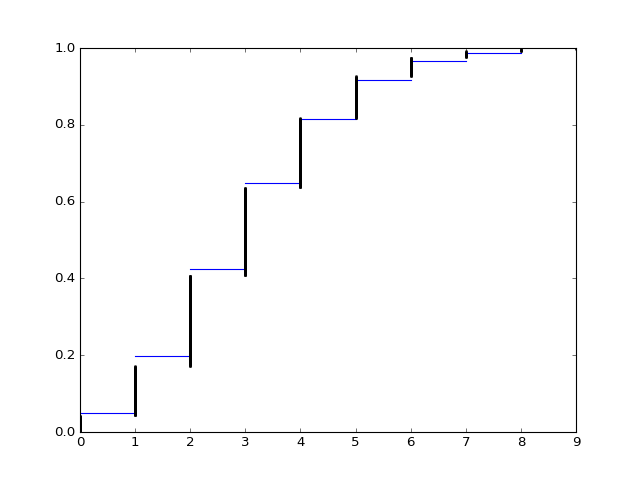

In [59]:
poiss_button = widgets.Button(description='Simulate')
poiss_l_selector = widgets.FloatSlider(min=0.01, max=10, value=3, description='$\lambda$')

fig_poiss_simulation, ax_poiss_simulation = plt.subplots()

def poisson_simulation(_lambda):
    data = [poisson(_lambda) for i in range(1000)]
    max_x = 9
    vals = np.arange(0, max_x)
    probs = [math.exp(-_lambda)]
    for i in range(1, max_x+1):
        probs.append(probs[-1]* _lambda /i)
    cum_probs = np.cumsum(probs)

    clear_output()
    ax_poiss_simulation.clear()
        
    for line in zip(zip(vals[:-1], vals[1:]), cum_probs):
        ax_poiss_simulation.plot(line[0], [line[1]]*2, 'b')
            
    x_ecdf, y_ecdf = ecdf(data)
    ax_poiss_simulation.plot(x_ecdf, y_ecdf, 'ko', markersize=2, alpha=.7)
    plt.ylim(0, 1)
    plt.xlim(0, max_x)
    
    display(fig_poiss_simulation)


poiss_button.on_click(lambda b: poisson_simulation(poiss_l_selector.value))
display(poiss_button)

_ = interact(poisson_simulation, _lambda=poiss_l_selector)

Note that, being the support of the Poisson distribution an infinite set, applying the strategy consisting in considering the possible specifications in decreasing probability order will not be feasible. However, the unimodality of the distribution suggests that once the $[0, 1]$-uniform random value $u$ has been generated, the first specification to be considered should be an integer value closer to the modal value, for instance $\lfloor \lambda \rfloor$: if $F_X(\lfloor \lambda \rfloor) \leq u$ the inverse transformation method will need only to consider all values $x \geq \lfloor \lambda \rfloor$. Otherwise, the algorithm will consider the values $x < \lfloor \lambda \rfloor$. Being $\lfloor \lambda \rfloor$ the unimodal value of the distribution, in both cases the considered values will be already sorted according to the decreasing values for the corresponding probabilities.

The original simulation algorithm will have an average time complexity equal to $\mathrm O(\lambda)$, simply because at each run the number of loop iteration will be proportional to the generated value of $X$, whose mean is $\lambda$. On the other hand, the optimized version of the algorithm will have an average complexity proportional to the expected value $\mathrm E(|X - \lambda|)$. This value can be estimated considering instead of $X$ its normal approximation $N$, that is a normal random variable having mean and variance equal to $\lambda$:

$$
\mathrm E(|X - \lambda|) \approx \mathrm E(|N - \lambda|)
= \sqrt{\lambda} \mathrm E \left( \frac{|N - \lambda|}{\sqrt{\lambda}} \right)
= \sqrt{\lambda} \mathrm E (|Z|),
$$

where $Z$ is distributed according to a standard normal distribution. Now

$$
\mathrm E (|Z|) = \int_{-\infty}^{+\infty} |z| \phi(z) \mathrm d z
                = 2 \int_0^{+\infty} z \phi(z) \mathrm d z
                = \sqrt{\frac{2}{\pi}} \int_0^{+\infty}z \mathrm e^{-z^2/2} \mathrm d z
                = \sqrt{\frac{2}{\pi}} \int_0^{+\infty}\mathrm e^{-r} \mathrm d r
                = \sqrt{\frac{2}{\pi}} \approx 0.798,
$$

where the last integral has been obtained through the substitution $r = z^2/2$. Thus the optimized version of the simulation algorithm has an average time complexity $\mathrm O(0.798 \sqrt{\lambda})$.

## Simulating an hypergeometric distribution ##

Let's consider the problem of selecting uniformly at random one of the possible permutations of the elements of the set $\{ 1, \dots, n \}$. A first algorithm solving this problem is the following:

- generate $n$ random values $u_1, \dots u_n$ uniformly distributed over $[0, 1]$,
- build the set $S = \{ (1, u_1), \dots (n, u_n) \}$,
- sort $S$ for nondecreasing values of the second component of its pairs,
- extract the first component of each element of the sorted set.

In [70]:
def generate_permutation(n):
    us = random.random(n)
    s = zip(np.arange(1, n+1), us)
    s.sort(key=lambda s: s[1])
    return zip(*s)[0]

In [74]:
generate_permutation(10)

(9, 7, 2, 8, 10, 4, 3, 6, 5, 1)

In the proposed algorithm the sorting operation dominates the other ones, thus the time complexity will be $\mathrm O(n \log n)$. Consider the following alternative algorithm:

In [77]:
def generate_permutation(n):
    p = np.arange(1, n+1)
    for i in range(n):
        j = uniform_discrete(n)
        p[i], p[j] = p[j], p[i]
    return p

In [79]:
generate_permutation(10)

array([ 8,  7,  4,  9,  6,  5,  3,  1, 10,  2])

This variant builds the list $[1, \dots, n]$ and subsequently considers all possible indices and swaps the corresponding element with another one chosen uniformly at random. Thus the complexity is in this case linear, that is it amounts to $\mathrm O(n)$.

Once a permutation has been generated randomly, it can be used in order to simulate a hypergeometric distribution. Let

- $N \in \mathbb N$ denote the total number of elements in the population,
- $K \in \{0, \dots, N \}$ denote the number of elements corresponding to a successful draw,
- $n \in \{0, \dots, N \}$ denote the number of extractions,
- $k  \in \{\max(0, n+K-N, \dots, \min(n, K) \}$ denote the number of successful extractions.

The process of drawing without replacement can be simulated easily: starting from a random permutation of $\{ 1, \dots, N \}$, its first $K$ elements will identify the successful draws, and the last $N-K$ one will identify unsuccesfull draws. Finally, the first $n$ items in a second random permutation will identify the drawn elements, thus it will suffice to check whether or not they belong to the set of successful draws.

In [94]:
def hypergeometric(N, K, n):
    p = generate_permutation(N)
    draws = generate_permutation(N)
    return sum([1 if d in p[:K] else 0 for d in draws[:n]])

In [95]:
hypergeometric(10, 4, 7)

3

If we are interested in simulating an hypergeometric distribution, there is actually no need to fully generate a permutation of the available items: consider indeed the following algorithm:

- $S = \{ \}$
- $r = 0$
- $k = 0$
- for each item $i \in \{ 1, \dots, N \}$:
  - with probability $\frac{n-r}{N-k}$:
    - $S = S \cup \{ i \}$
    - $r = r + 1$
    - if $r > n$: break
  - $k = k + 1$
- return $S$

Within the algorithm loop, $k$ denotes the number of items considered so far and $r$ is the number of items already added to the solution to be returned, which will contain a combination of $n$ items chosen among the $N$ available ones so that all $\binom{N}{n}$ possible combinations are drawn with uniform probabilities.

In [97]:
def generate_combination(N, n):
    s = []
    r = 0
    k = 0
    for i in np.arange(1, N+1):
        if random.random() < float(n-r)/(N-k):
            s.append(i)
            r += 1
            if r > n:
                break
        k += 1
    return s

In [104]:
generate_combination(10, 3)

[1, 2, 4]

Note that the probabilistic part of the proposed algorithm ensures that the returned list always have size equal to $n$: indeed, if at any given moment during the execution there are $n-r$ elements yet to be considered for inclusion, $k = N - (n-r)$ and thus the probability of adding the next item to $S$ will be 1. Subsequently, both $r$ and $k$ will be incremented, thus all subsequent steps will include the remaingin items into the returned solution. This can be exemplified as follows: suppose that $N=5$ and $n=3$, and assume that the first two elements (namely, 1 and 2) have been discarded by the algorithm, so that $S=\{ \}$, $r=0$, and $k=2$. When the third item will be considered, the probability of including it to the returned combination will be

$$\frac{n-r}/{N-k} = \frac{3-0}{5-2} = 1,$$

thus at the end of the iteration we will have $S=\{ 3 \}$, $r=1$, and $k=3$. The next considered item will be 4, and now $\frac{n-r}/{N-k} = \frac{3-1}{5-3} = 1$, thus also this item will be included in $S$. Idem for the last item, so that the algorithm will return $S=\{ 3, 4, 5 \}$.

Once $S$ has been generated, it can be used as the set of successful results in a repeated draw experiment without replacement at the basis of the simulation of a hypergeometric distribution. As a final remark, note that when $K > N/2$ a more clever implementation would generate all items related to unsuccessful draws, rather than those giving rise to a success.

### Exercises ###

- Find out for which values of $\lambda$ the optimized version of the Poisson simulation has a smaller average complexity than the original one.
- Apply the inverse transformation technique in order to simulate the binomial distribution.
- Check that the algorithm found in the previous point can be optimized using the technique described for the Poisson distribution.